In [88]:
import tensorflow as tf 
from keras.models import Sequential,load_model,Model
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, Flatten,Input,Embedding, LSTM, Dropout
import re
import numpy as np
from keras.optimizers import Adam


Cornell Movie dataset: https://www.kaggle.com/code/programminghut/seq2seq-chatbot-keras-with-attention/input?scriptVersionId=40597744

Youtube Tutorial: https://www.youtube.com/watch?v=Xg2wOBU9v90&list=PLTuKYqpidPXbulRHl8HL7JLRQXwDlqpLO&ab_channel=ProgrammingHut

### importing the dataset 

Split the data to be read line by line

In [89]:
# get the data, and ignore errors, split each new line as new data entry
lines = open('cornell movie-dialogs corpus/movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conversations = open('cornell movie-dialogs corpus/movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n')

# Pre processing the Text data

In [90]:
# create nested lists by splitting for exchanges
exchanges =[]
for conver in conversations:
    exchanges.append({conver.split(' +++$+++ ')[-1]: [item[1:-1].replace("'", "").replace(",", "") for 
    item in conver.split(' +++$+++ ')[-1][1:-1].split()]})
#exchanges


In [91]:
#create a dictionary
dialog ={}
for line in lines:
    dialog[line.split(' +++$+++ ')[0]] = line.split(' +++$+++ ')[-1]
#dialog

In [92]:
# Create a list for questions and answers
questions = []
answers = []

# Iterate through the conversation list
for exchange in exchanges:
    # Extract the list of conversation exchanges from the dictionary
    conversation = list(exchange.values())[0]
    
    # Iterate through the conversation exchanges
    for i in range(len(conversation) - 1):
        answer_key = conversation[i + 1]
        question_key = conversation[i ]
        
        # Use dialog dictionary to map keys to actual text
        question_text = dialog.get(question_key, '')
        answer_text = dialog.get(answer_key, '')
        
        # Append the mapped text to questions and answers
        questions.append(question_text)
        answers.append(answer_text)

# Now 'questions' and 'answers' lists should contain the extracted conversation text
#print(questions)
#print(answers)


In [93]:
#delete variables that we are no longer using

del(conversation, i, dialog, conversations, line, lines, exchanges, conver)

In [94]:
# put questions and answers by fix length of questions
sorted_questions =[]
sorted_answers =[]
for i in range(len(questions)):
    if len(questions[i])<16:
        sorted_questions.append(questions[i])
        sorted_answers.append(answers[i])

# better way to do this?

In [95]:
# clean the text data
#create a regular expression
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm","i am",text)
    text = re.sub(r"he's","he is",text)
    text = re.sub(r"she's","she is",text)
    text = re.sub(r"that's","that is",text)
    text= re.sub(r"what's","what is",text)
    text = re.sub(r"where's","where is",text)
    text = re.sub(r"\'ll", "will",text)
    text = re.sub(r"\'ve", "have",text)
    text = re.sub(r"\'re","are",text)
    text = re.sub(r"\d","would",text)
    text = re.sub(r"won't","will not",text)
    text = re.sub(r"can't","can not",text)
    text = re.sub(r"[^\w\s]", "", text)
    return(text)


In [96]:
#apply cleaning to our lists

clean_questions=[]
clean_answers=[]

for line in sorted_questions:
    clean_questions.append(clean_text(line))

for line in sorted_answers:
    clean_answers.append(clean_text(line))

#clean_answers

In [97]:
#max length of 11
for i in range(len(clean_answers)):
    clean_answers[i] = ' '.join(clean_answers[i].split()[:11])

In [98]:
#delete variables that are done
#del(answers, i, line, questions, sorted_answers, sorted_questions)
print(len(clean_questions))


42851


In [99]:
#lessening amount of data
#clean_answers = clean_answers[:30000]
#clean_questions = clean_questions[:30000]

In [100]:
# create vocabulary
#sentances split into  words and counted 
#dictionary
word2count={}
for line in clean_questions:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1
for line in clean_answers:
    for word in line.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

#delete
del(word,line)
#print(word2count)

In [101]:
#remove less used words
threshold =5

vocabulary ={}
word_number =0
for word,count in word2count.items():
    if count>= threshold:
        vocabulary[word] =word_number
        word_number +=1
#delete
del(word2count, word, count, threshold, word_number)
#print(vocabulary)

In [102]:
# we need to create a beginning of string and end of string

for i in range(len(clean_answers)):
    clean_answers[i]= ' <SOS> ' + clean_answers[i] + ' <EOS> ' 

clean_answers

[' <SOS> the thing is cameron i am at the mercy of a <EOS> ',
 ' <SOS> unsolved mystery she used to be really popular when she started <EOS> ',
 ' <SOS> where <EOS> ',
 ' <SOS> i really really really wanna go but i can not not <EOS> ',
 ' <SOS> lesbian no i found a picture of jared leto in one <EOS> ',
 ' <SOS> looks like things worked out tonight huh <EOS> ',
 ' <SOS> you never wanted to go out with me did you <EOS> ',
 ' <SOS> then that is all you had to say <EOS> ',
 ' <SOS> you always been this selfish <EOS> ',
 ' <SOS> me this endless blonde babble i am like boring myself <EOS> ',
 ' <SOS> like my fear of wearing pastels <EOS> ',
 ' <SOS> okay youare gonna need to learn how to lie <EOS> ',
 ' <SOS> lets go <EOS> ',
 ' <SOS> i hope so <EOS> ',
 ' <SOS> they do not <EOS> ',
 ' <SOS> you might wanna think about it <EOS> ',
 ' <SOS> joey <EOS> ',
 ' <SOS> would you mind getting me a drink cameron <EOS> ',
 ' <SOS> expensive <EOS> ',
 ' <SOS> its a gay cruise line but iwill be like wea

In [103]:
#add tokens to vocabulary eg pad is padding 
tokens= ['<PAD>','<EOS>','<OUT>','<SOS>']
X= len(vocabulary)
for token in tokens:
    vocabulary[token] = X 
    X += 1
vocabulary['cameron'] = vocabulary['<PAD>']
vocabulary['<PAD>']=0
#delete
del(token, tokens ,X)

In [104]:
# inverse answers
inverse_vocabulary={w:v for v,w in vocabulary.items()}


#inverse_vocabulary.items
#vocabulary

#creating inputs

In [105]:
#encoder input - used to calculate the input 
encoder_inp = []
for line in clean_questions:
    list=[]
    for word in line.split():
        if word not in vocabulary:
            #check if word is in vocabulary
            list.append(vocabulary['<OUT>'])
        else:
            #add word to list
            list.append(vocabulary[word])
    encoder_inp.append(list)

encoder_inp

[[4068],
 [1],
 [2],
 [3, 4],
 [5, 6, 7, 8],
 [9],
 [10, 11],
 [12, 13],
 [14],
 [15, 16],
 [17, 18, 19],
 [13],
 [20],
 [5, 21],
 [22, 23, 24],
 [13],
 [25],
 [26],
 [27, 28],
 [29, 30],
 [31],
 [9, 32],
 [15, 6, 33],
 [34, 19, 35],
 [15],
 [1],
 [19, 36, 15],
 [14],
 [37, 6, 7],
 [38, 39],
 [19, 40, 41, 42],
 [43, 10],
 [43, 13],
 [1],
 [13, 14],
 [44],
 [4070],
 [45, 46],
 [25, 6, 5],
 [1, 7],
 [15, 47, 48],
 [49, 6, 50],
 [3],
 [5, 51, 41],
 [52, 53, 54],
 [55],
 [56],
 [19, 57, 58],
 [10, 59, 60, 61],
 [15],
 [62, 61],
 [23, 15],
 [63],
 [64, 19, 65],
 [66, 67, 68],
 [19, 69, 4070],
 [70, 37],
 [15, 6, 71],
 [72, 61, 73],
 [74, 49, 75],
 [19, 76],
 [25],
 [77, 41],
 [15, 6, 71],
 [21],
 [10, 78, 19],
 [3, 10, 23],
 [1],
 [25],
 [4070],
 [10, 79, 48],
 [80, 81, 42],
 [82],
 [83],
 [13, 19, 84],
 [23, 15],
 [85, 8, 86],
 [25],
 [87],
 [19, 64, 88],
 [4070],
 [4070],
 [89, 90],
 [91],
 [92],
 [19, 42, 93, 61],
 [94, 4070],
 [4070],
 [17, 95],
 [4070],
 [10, 79, 4070],
 [15],
 [13],
 

In [106]:
#decoder input - used to calculate the output
decoder_inp = []
for line in clean_answers:
    list=[]
    for word in line.split():
        if word not in vocabulary:
            #check if word is in vocabulary
            list.append(vocabulary['<OUT>'])
        else:
            #add word to list
            list.append(vocabulary[word])
    decoder_inp.append(list)

decoder_inp

[[4071, 17, 794, 6, 4068, 10, 59, 431, 17, 4070, 103, 8, 4069],
 [4071, 4070, 1394, 5, 1560, 24, 347, 183, 3246, 105, 5, 2057, 4069],
 [4071, 52, 4069],
 [4071, 10, 183, 183, 183, 1434, 39, 14, 10, 229, 7, 7, 4069],
 [4071, 4070, 13, 10, 955, 8, 1976, 103, 4070, 4070, 124, 252, 4069],
 [4071, 656, 34, 1306, 1055, 46, 154, 98, 4069],
 [4071, 19, 44, 1710, 24, 39, 46, 319, 41, 36, 19, 4069],
 [4071, 121, 37, 6, 220, 19, 585, 24, 75, 4069],
 [4071, 19, 1204, 258, 71, 4070, 4069],
 [4071, 41, 71, 4070, 2231, 4070, 10, 59, 34, 2066, 765, 4069],
 [4071, 34, 128, 631, 103, 3131, 4070, 4069],
 [4071, 21, 141, 1578, 743, 24, 2391, 92, 24, 882, 4069],
 [4071, 205, 39, 4069],
 [4071, 10, 630, 88, 4069],
 [4071, 22, 23, 7, 4069],
 [4071, 19, 1239, 1434, 106, 47, 61, 4069],
 [4071, 32, 4069],
 [4071, 244, 19, 945, 1554, 41, 8, 263, 4068, 4069],
 [4071, 3247, 4069],
 [4071, 27, 8, 822, 4070, 500, 14, 175, 347, 34, 3131, 8, 4069],
 [4071, 128, 944, 116, 309, 164, 8, 89, 655, 431, 1429, 17, 4069],
 [4

In [107]:
#delete
del(clean_answers, clean_questions, line, list,word)

# keras

In [108]:
# fix length of 16 - 0 means padding 0 will point to padding value

encoder_inp = pad_sequences(encoder_inp,13, padding='post', truncating='post')
decoder_inp = pad_sequences(decoder_inp,13, padding='post', truncating='post')

In [109]:

decoder_final_output=[]
for i in decoder_inp:
    decoder_final_output.append(i[1:])

decoder_final_output=pad_sequences(decoder_final_output,13, padding='post',truncating='post')

#decoder_final_output

Training and testing

In [110]:


# Split the data into training and test sets
encoder_train, encoder_test, decoder_train, decoder_test = train_test_split(
    encoder_inp, decoder_inp, test_size=0.4, random_state=42)

# Split decoder_final_output into training and test sets (80% train, 20% test)
decoder_final_output_train, decoder_final_output_test = train_test_split(
    decoder_final_output, test_size=0.4, random_state=42)
# Print the shapes to verify
"""
print("encoder_train shape:", encoder_train.shape)
print("encoder_test shape:", encoder_test.shape)
print("decoder_train shape:", decoder_train.shape)
print("decoder_test shape:", decoder_test.shape)
print(decoder_final_output_train.shape)
# Print the first few words from the vocabulary
for word, index in list(vocabulary.items())[:10]:
    print(f"Word: {word}, Index: {index}")"""




'\nprint("encoder_train shape:", encoder_train.shape)\nprint("encoder_test shape:", encoder_test.shape)\nprint("decoder_train shape:", decoder_train.shape)\nprint("decoder_test shape:", decoder_test.shape)\nprint(decoder_final_output_train.shape)\n# Print the first few words from the vocabulary\nfor word, index in list(vocabulary.items())[:10]:\n    print(f"Word: {word}, Index: {index}")'

final output train size was incorrect, had to fix it like this

In [111]:

VOCAB_SIZE = len(vocabulary) + 1  # +1 for padding
# One-hot encode decoder_final_output_train
decoder_final_output_train_encoded = to_categorical(decoder_final_output_train, num_classes=VOCAB_SIZE)
decoder_final_output_test_encoded = to_categorical(decoder_final_output_test, num_classes=VOCAB_SIZE)

# Verify the shape of the encoded data
print("Shape of one-hot encoded decoder_final_output_train:", decoder_final_output_train_encoded.shape)


Shape of one-hot encoded decoder_final_output_train: (25710, 13, 4073)


In [112]:


def LSTM_model(vocabulary_size, embedding_dim, lstm_units):
    # Input layers
    enc_inp = Input(shape=(13,))
    dec_inp = Input(shape=(13,))

    # Embedding layers
    embed = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=13, trainable=True)

    enc_embed = embed(enc_inp)
    dec_embed = embed(dec_inp)

    # LSTM layers
    lstm1 = LSTM(lstm_units, return_sequences=True, return_state=True)
    enc_op, h1, c1 = lstm1(enc_embed)
    enc_state = [h1, c1]
    #dropout added to improve model performance
    dropout_rate=0.15
 # Add a dropout layer after the first LSTM
    enc_op = Dropout(rate=dropout_rate)(enc_op)

    lstm2 = LSTM(lstm_units, return_sequences=True, return_state=True)
    dec_op, _, _ = lstm2(dec_embed, initial_state=enc_state)

    # Dense layer
    dense = Dense(vocabulary_size, activation='softmax')
    dense_op = dense(dec_op)
    # Add a dropout layer after the second LSTM
    dec_op = Dropout(rate=dropout_rate)(dec_op)
    # Create the model
    model = Model([enc_inp, dec_inp], dense_op)
# added learning rate as an attempt to have the model converge better
    #learning_rate = 0.01  # Set your desired learning rate
    #optimizer = Adam(learning_rate=learning_rate)
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model

vocabulary_size = VOCAB_SIZE
embedding_dim = 65
lstm_units= 500
# Create the LSTM model
lstm_model = LSTM_model(vocabulary_size, embedding_dim, lstm_units)



at first I had 30 epochs, but that resulted in overfitting, the graph showd that the validation loss started to increase at about 15 epochs, so I changed the epochs to 15

In [113]:

# Set number of epochs and batch size
epochs = 15
batch_size = 32
#model.fit([encoder_train, decoder_train], decoder_final_output_train_encoded, epochs=10, batch_size=64)
history = lstm_model.fit(
    [encoder_train, decoder_train], 
    decoder_final_output_train_encoded, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=([encoder_test, decoder_test], decoder_final_output_test_encoded)
)



Epoch 1/15
804/804 [==============================] - 218s 266ms/step - loss: 3.2111 - accuracy: 0.4938 - val_loss: 2.9471 - val_accuracy: 0.5210
Epoch 2/15
804/804 [==============================] - 208s 259ms/step - loss: 2.8423 - accuracy: 0.5286 - val_loss: 2.7792 - val_accuracy: 0.5367
Epoch 3/15
804/804 [==============================] - 208s 258ms/step - loss: 2.7044 - accuracy: 0.5399 - val_loss: 2.7114 - val_accuracy: 0.5424
Epoch 4/15
804/804 [==============================] - 207s 257ms/step - loss: 2.6156 - accuracy: 0.5459 - val_loss: 2.6761 - val_accuracy: 0.5454
Epoch 5/15
804/804 [==============================] - 199s 248ms/step - loss: 2.5445 - accuracy: 0.5499 - val_loss: 2.6578 - val_accuracy: 0.5484
Epoch 6/15
804/804 [==============================] - 208s 259ms/step - loss: 2.4823 - accuracy: 0.5531 - val_loss: 2.6500 - val_accuracy: 0.5497
Epoch 7/15
804/804 [==============================] - 206s 256ms/step - loss: 2.4206 - accuracy: 0.5557 - val_loss: 2.6540 -

finding error- not able to fit data I forgot to add the decoder_final_output into the model

In [114]:
# One-hot encode decoder_final_output_test
decoder_final_output_test_encoded = to_categorical(decoder_final_output_test, num_classes=VOCAB_SIZE)

# Evaluate the model on the test data
loss, accuracy = lstm_model.evaluate([encoder_test, decoder_test], decoder_final_output_test_encoded)

# Print the test loss and accuracy
print(f"Test loss: {loss}, Test accuracy: {accuracy}")


536/536 [==============================] - 54s 100ms/step - loss: 2.8952 - accuracy: 0.5494
Test loss: 2.8952419757843018, Test accuracy: 0.5493845343589783


### results of testing:
the model has an accuracy of approximately 98.7% with a loss of 0.1 (average loss over all examples )- this was a result of overfitting the model
after .
After hypertuning the model loss is 2.7 and accuracy 0.55 - this result is underfitting the model

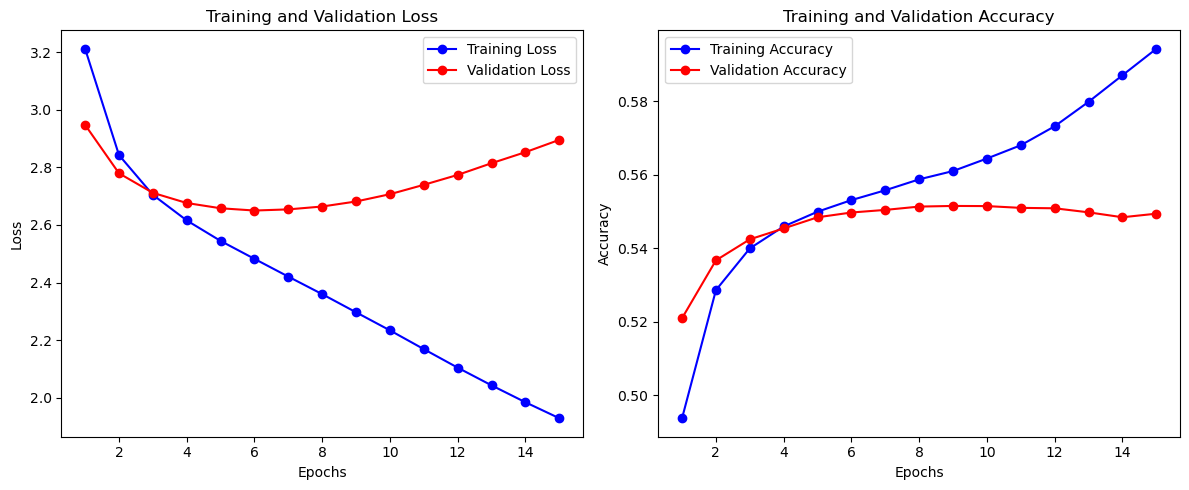

In [115]:
import matplotlib.pyplot as plt


# Assuming you have access to training and validation data
train_loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss
train_accuracy = history.history['accuracy']  # Training accuracy
val_accuracy = history.history['val_accuracy']  # Validation accuracy

# Create an array of epoch numbers 
epochs1 = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs1, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs1, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs1, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs1, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### results:
first round of results
training data is more accurate than the test data, therefore the model is overfitting to improve the accuracy of the data 
SECOND round of results
The same thing happens the training data is more accurate than the test data

In [117]:
# The path to save the weights
weights_filename = 'lstm_model_weights.h5'

# Save the model weights
lstm_model.save(weights_filename)
